In [20]:
import numpy as np
import os
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import pandas as pd
from tensorflow.keras.layers import Dense , Dropout
from scikeras.wrappers import KerasRegressor 
from tensorflow.keras.callbacks import EarlyStopping
import time
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.optimizers import Adam
from keras.regularizers import l2
from keras.callbacks import EarlyStopping
from keras_tuner import RandomSearch
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from sklearn.model_selection import GridSearchCV

In [21]:
#data = pd.read_pickle('C:/Users/erikm/Desktop/Diplomarbeit Erik Marr/Daten/Finish/TPath_300_finish_data.pkl')
data = pd.read_pickle('C:/Users/erikm/Desktop/Diplomarbeit Erik Marr/Daten/Finish/Finish_D1_I7000_F9000/TPath_500_finish_data_D1.pkl')

data

,X-Koordinate,Y-Koordinate,Zeitpunkt,Strom,Kraft,Temperatur
0,0.0000,-0.00200,500,7000,9000,669.05
1,0.0000,-0.00199,500,7000,9000,675.83
2,0.0000,-0.00198,500,7000,9000,682.81
3,0.0000,-0.00197,500,7000,9000,689.82
4,0.0000,-0.00196,500,7000,9000,696.80
...,...,...,...,...,...,...
100646,0.0025,0.00196,500,7000,9000,578.47
100647,0.0025,0.00197,500,7000,9000,576.89
100648,0.0025,0.00198,500,7000,9000,575.32
100649,0.0025,0.00199,500,7000,9000,573.76


In [22]:
df = data.drop(data.columns[2:5], axis = 1)
df['Temperatur'].describe()

count    100651.000000
mean       1144.030064
std         264.135723
min         572.200000
25%         937.330000
50%        1201.100000
75%        1368.700000
max        1520.000000
Name: Temperatur, dtype: float64

In [23]:
df1 = df.sample(frac=1, random_state=42)  # Hier wird 42 als Random State verwendet, um die Ergebnisse reproduzierbar zu machen

print(df1)
df_reset = df1.reset_index(drop=True)
df_reset

       X-Koordinate  Y-Koordinate  Temperatur
83145       0.00207      -0.00062      1282.2
66701       0.00166      -0.00065      1347.6
91325       0.00227       0.00098      1094.6
46593       0.00116      -0.00123      1175.7
49518       0.00123      -0.00005      1459.2
...             ...           ...         ...
6265        0.00015       0.00050      1439.1
54886       0.00136       0.00150       876.7
76820       0.00191       0.00029      1335.8
860         0.00002      -0.00142      1071.2
15795       0.00039      -0.00044      1488.1

[100651 rows x 3 columns]


,X-Koordinate,Y-Koordinate,Temperatur
0,0.00207,-0.00062,1282.2
1,0.00166,-0.00065,1347.6
2,0.00227,0.00098,1094.6
3,0.00116,-0.00123,1175.7
4,0.00123,-0.00005,1459.2
...,...,...,...
100646,0.00015,0.00050,1439.1
100647,0.00136,0.00150,876.7
100648,0.00191,0.00029,1335.8
100649,0.00002,-0.00142,1071.2


In [24]:
label = df_reset["Temperatur"]
# Korrektur: Verwenden Sie den Spaltennamen direkt, ohne Indexierung der columns-Eigenschaft
df1 = df_reset.drop("Temperatur", axis=1)
X = df1
y = label


In [25]:
X.describe()

,X-Koordinate,Y-Koordinate
count,100651.000000,1.006510e+05
mean,0.001250,1.103042e-20
std,0.000725,1.157589e-03
min,0.000000,-2.000000e-03
25%,0.000620,-1.000000e-03
50%,0.001250,4.529900e-18
75%,0.001880,1.000000e-03
max,0.002500,2.000000e-03


In [26]:
y.describe()


count    100651.000000
mean       1144.030064
std         264.135723
min         572.200000
25%         937.330000
50%        1201.100000
75%        1368.700000
max        1520.000000
Name: Temperatur, dtype: float64

In [27]:
 # train_df enthält 80% der Daten, test_df enthält 20% der Daten
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)


In [28]:
# Initialisiere einen MinMaxScaler für die Features
scaler_features = MinMaxScaler()
scaler_features2 = MinMaxScaler()
# Skaliere X_train und X_test
X_train_scaled = scaler_features.fit_transform(X_train)
X_test_scaled = scaler_features.transform(X_test)  # Nutze unterschiedliche Skalierungsparameter

# Initialisiere einen SEPARATEN MinMaxScaler für das Ziel, wenn nötig
scaler_target = MinMaxScaler()


# Skaliere y_train und y_test. Beachte, dass y_train.reshape(-1, 1) verwendet wird, da MinMaxScaler 
# erwartet, dass die Eingaben als 2D-Arrays kommen, und Ziele normalerweise als 1D-Arrays vorliegen.
y_train_scaled = scaler_target.fit_transform(y_train.values.reshape(-1, 1))
y_test_scaled = scaler_target.transform(y_test.values.reshape(-1, 1))


In [29]:
X_train_scaled

array([[0.416 , 0.5725],
       [0.812 , 0.7325],
       [0.628 , 0.5075],
       ...,
       [0.604 , 0.3875],
       [0.748 , 0.65  ],
       [0.028 , 0.6225]])

In [30]:
start_time = time.time()
# Netzwerkarchitektur
model = Sequential([
    # Eingabeschicht

    Dense(256, activation='relu', input_shape=(2,), kernel_initializer='he_uniform', kernel_regularizer=l2(0.0001)),

    Dense(128, activation='relu', kernel_initializer='he_uniform', kernel_regularizer=l2(0.0001)),

    Dense(160, activation='relu', kernel_initializer='he_uniform', kernel_regularizer=l2(0.0001)),

    Dense(224, activation='relu', kernel_initializer='he_uniform', kernel_regularizer=l2(0.0001)),

    Dense(112, activation='relu', kernel_initializer='he_uniform', kernel_regularizer=l2(0.0001)),

    Dense(320, activation='relu', kernel_initializer='he_uniform', kernel_regularizer=l2(0.0001)),
    
    Dense(16, activation='relu', kernel_initializer='he_uniform', kernel_regularizer=l2(0.0001)),
    
    Dense(112, activation='relu', kernel_initializer='he_uniform', kernel_regularizer=l2(0.0001)),
    
    #Dense(240, activation='relu', kernel_initializer='he_uniform', kernel_regularizer=l2(0.0001)),
    
    #Dense(48, activation='relu', kernel_initializer='he_uniform', kernel_regularizer=l2(0.0001)),
    
    Dense(1 , activation = 'linear')
])

# Optimierer
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)

# Modell kompilieren (Verwendung von mean_squared_error als Verlustfunktion für Regression)
model.compile(optimizer=optimizer,
              loss='mean_squared_error',
              metrics=['mae'])  # Metriken für Regression: Mean Absolute Error und Mean Squared Error

# Early Stopping Callback
early_stopping = EarlyStopping(monitor='val_loss', patience=5, verbose=2, mode='min', restore_best_weights=True)#, min_delta = 0.00005)

# Trainingsparameter
batch_size = 100
epochs = 400

# Modell trainieren (Annahme: X_train, y_train, X_val, y_val sind vordefiniert)
history = model.fit(X_train_scaled, y_train_scaled,
                    batch_size=batch_size,
                    epochs=epochs,
                    validation_split=0.2,
                    callbacks=[early_stopping],
                    verbose = 1)

end_time = time.time()

# Berechne die Dauer
duration = end_time - start_time

print(f"Die Ausführungszeit betrug {duration} Sekunden.")

Epoch 1/400
645/645 [==============================] - 3s 3ms/step - loss: 0.2869 - mae: 0.1414 - val_loss: 0.1944 - val_mae: 0.0165
Epoch 2/400
645/645 [==============================] - 1s 2ms/step - loss: 0.1763 - mae: 0.0114 - val_loss: 0.1621 - val_mae: 0.0065
Epoch 3/400
645/645 [==============================] - 1s 2ms/step - loss: 0.1535 - mae: 0.0109 - val_loss: 0.1462 - val_mae: 0.0077
Epoch 4/400
645/645 [==============================] - 1s 2ms/step - loss: 0.1416 - mae: 0.0140 - val_loss: 0.1368 - val_mae: 0.0076
Epoch 5/400
645/645 [==============================] - 1s 2ms/step - loss: 0.1335 - mae: 0.0120 - val_loss: 0.1300 - val_mae: 0.0092
Epoch 6/400
645/645 [==============================] - 1s 2ms/step - loss: 0.1271 - mae: 0.0105 - val_loss: 0.1241 - val_mae: 0.0123
Epoch 7/400
645/645 [==============================] - 1s 2ms/step - loss: 0.1212 - mae: 0.0099 - val_loss: 0.1182 - val_mae: 0.0078
Epoch 8/400
645/645 [==============================] - 1s 2ms/step - 

In [31]:
results = model.evaluate(X_test_scaled, y_test_scaled, verbose=2)
results

630/630 - 1s - loss: 8.9852e-04 - mae: 0.0027 - 642ms/epoch - 1ms/step


[0.0008985208696685731, 0.0027488218620419502]

In [32]:
scaled_predicted_values = model.predict(X_test_scaled, verbose = 0)

# Führen Sie die Rücktransformation der skalierten Werte durch
original_predicted_values = scaler_target.inverse_transform(scaled_predicted_values)
original_actual_values = scaler_target.inverse_transform(y_test_scaled)  # y_test sind die skalierten tatsächlichen Werte
print(f' Bsp. Predicted: {original_predicted_values[1000]} Actual: {original_actual_values[1000]} ')

def calculate_mae(list1, list2):
    # Stelle sicher, dass beide Listen die gleiche Länge haben
    if len(list1) != len(list2):
        raise ValueError("Listen müssen die gleiche Länge haben")

    # Berechne die absolute Differenz zwischen den Elementen der Listen
    differences = [abs(x - y) for x, y in zip(list1, list2)]

    # Berechne den Durchschnitt der absoluten Differenzen
    mae = sum(differences) / len(differences)

    return mae

# Beispiel
list1 = original_predicted_values
list2 = original_actual_values

mae = calculate_mae(list1, list2)
print(f"Durchschnittliche Abweichung (MAE): {mae}")


 Bsp. Predicted: [1193.7445] Actual: [1195.9] 
Durchschnittliche Abweichung (MAE): [2.60533657]


In [33]:
def calculate_r_squared(predicted, actual):
    # Berechnung des Mittelwerts der tatsächlichen Werte
    mean_actual = sum(actual) / len(actual)
    
    # Berechnung der totalen Summe der Quadrate (SST)
    sst = sum((x - mean_actual) ** 2 for x in actual)
    
    # Berechnung der Summe der Quadrate der Residuen (SSE)
    sse = sum((actual[i] - predicted[i]) ** 2 for i in range(len(actual)))
    
    # Berechnung des R^2-Wertes
    r_squared = 1 - (sse / sst)
    
    return r_squared

# Berechnung von R^2 mit den bereitgestellten Listen
r_squared = calculate_r_squared(list1, list2)

print(f"R^2: {r_squared}")

R^2: [0.99978783]


In [34]:
df_result = pd.DataFrame({'Echt': [val[0] for val in list1], 'Vorhergesagt': [val[0] for val in list2]})
df_result['X-Koordinate'] = X_test_scaled[:, 0]
df_result['Y-Koordinate'] = X_test_scaled[:, 1]

df_result['Differenz'] = df_result['Echt'] - df_result['Vorhergesagt']
df_result['Differenz'].sort_values()
sorted_df = df_result.sort_values(by= 'Differenz')
Anzahl_Punkte = (sorted_df['Differenz'] > 20).sum()
print("Anzahl der Werte die kleiner sind:", Anzahl_Punkte)

sorted_df

Anzahl der Werte die kleiner sind: 8


,Echt,Vorhergesagt,X-Koordinate,Y-Koordinate,Differenz
19281,777.887451,807.84,1.000,0.9125,-29.952549
14143,802.839111,832.75,1.000,0.9025,-29.910889
16514,809.072205,838.63,1.000,0.9000,-29.557795
4177,815.301086,844.45,1.000,0.8975,-29.148914
16594,827.754272,855.66,1.000,0.8925,-27.905728
...,...,...,...,...,...
15061,608.071289,587.18,0.956,0.9775,20.891289
11939,608.316162,586.88,0.964,0.9775,21.436162
14839,621.090210,599.38,0.956,0.9725,21.710210
13809,615.559082,593.15,0.988,0.9750,22.409082


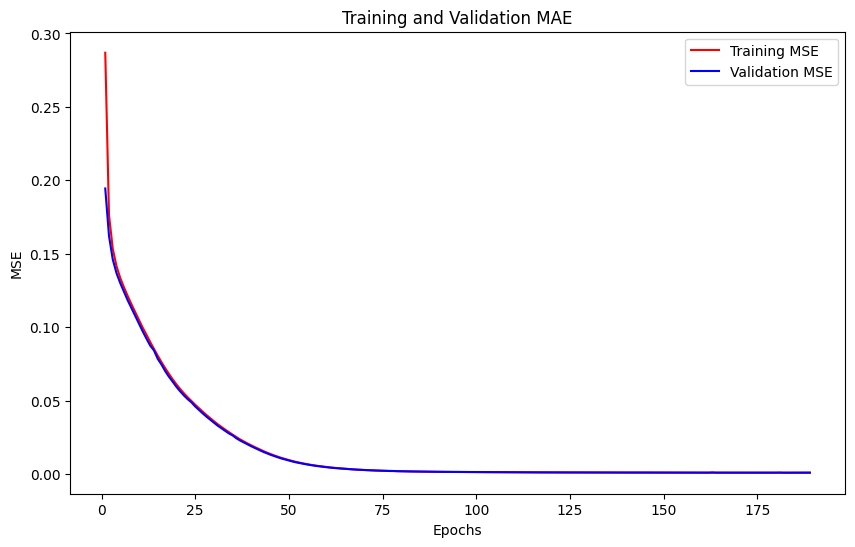

In [35]:
mae = history.history['loss']
val_mae = history.history['val_loss']

epochs = range(1, len(mae) + 1)
# MAE Diagramm
plt.figure(figsize=(10, 6))
plt.plot(epochs, mae, 'r', label='Training MSE')
plt.plot(epochs, val_mae, 'b', label='Validation MSE')
plt.title('Training and Validation MAE')
plt.xlabel('Epochs')
plt.ylabel('MSE')
plt.legend()
plt.show()


# GridSearch
Grid Search bietet die Vorteile der anpassbaren Rechenzeit sowie die Möglichkeit des EInsatzes von Verteilungen. So können theoretisch Hyperparamterkonfuigurationen gefunden wende, welche durch GridSearch nicht auffindbar wären. ZUdem ist das Ziel der Hyperparamteroptimierung eine Einstellung zu finden, welche auf Trainings und Testset gut angepasst ist. Die EInstellung muss nicht die bestmöglichste Einstellung sein, sondern eine Einstellung die das gewähltre Problem gut wiederspiegelt. 
Bayesian Optimierung

In [36]:
# def build_model(learning_rate=0.001, activation='relu', regularization=0.0001, dropout_rate=0.0):
#     model = Sequential()
#     model.add(Dense(320, activation=activation, input_shape=(2,), kernel_initializer='he_uniform', kernel_regularizer=l2(regularization)))
#     model.add(Dropout(dropout_rate))
# 
#     model.add(Dense(176, activation=activation, kernel_initializer='he_uniform', kernel_regularizer=l2(regularization)))
#     model.add(Dropout(dropout_rate))
# 
#     model.add(Dense(288, activation=activation, kernel_initializer='he_uniform', kernel_regularizer=l2(regularization)))
#     model.add(Dropout(dropout_rate))
# 
#     model.add(Dense(192, activation=activation, kernel_initializer='he_uniform', kernel_regularizer=l2(regularization)))
#     model.add(Dropout(dropout_rate))
# 
#     model.add(Dense(208, activation=activation, kernel_initializer='he_uniform', kernel_regularizer=l2(regularization)))
#     model.add(Dropout(dropout_rate))
# 
#     model.add(Dense(224, activation=activation, kernel_initializer='he_uniform', kernel_regularizer=l2(regularization)))
#     model.add(Dropout(dropout_rate))
# 
#     model.add(Dense(80, activation=activation, kernel_initializer='he_uniform', kernel_regularizer=l2(regularization)))
#     model.add(Dropout(dropout_rate))
# 
#     model.add(Dense(304, activation=activation, kernel_initializer='he_uniform', kernel_regularizer=l2(regularization)))
#     model.add(Dropout(dropout_rate)) 
# 
#     model.add(Dense(240, activation=activation, kernel_initializer='he_uniform', kernel_regularizer=l2(regularization)))
#     model.add(Dropout(dropout_rate))   
# 
#     model.add(Dense(48, activation=activation, kernel_initializer='he_uniform', kernel_regularizer=l2(regularization)))
#     model.add(Dropout(dropout_rate))
# 
#     model.add(Dense(1, activation='linear'))
#     model.compile(optimizer=Adam(learning_rate=learning_rate), loss='mean_squared_error', metrics=['mae'])
#     return model
# 
# # Verwenden Sie eine Funktion, um das Modell zu instanziieren, für scikit-learn Wrapper
# model = KerasRegressor(model=build_model, verbose=2)
# 
# # Anpassung der Parameter im param_grid
# param_grid = {
#     'model__learning_rate': [0.01, 0.001, 0.0001],
#     'model__regularization': [0.001, 0.0001],
#     'fit__batch_size': [100, 200, 400, 800],
#     'fit__epochs': [50],
#     'model__dropout_rate' : [0.0, 0.1, 0.2]
# }
# 
# grid_search = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=3, verbose=2)
# # Hinweis: Stellen Sie sicher, dass Ihre Daten (X_train_scaled, y_train_scaled) korrekt definiert sind
# grid_result = grid_search.fit(X_train_scaled, y_train_scaled)
# # Beste Parameter und Score ausgeben
# print("Beste Parameter:", grid_search.best_params_)
# print("Beste Genauigkeit:", grid_search.best_score_)
# 
# with open("grid_search_D1_2.txt", "w") as f:
#     f.write(f"Beste Parameter: {grid_search.best_params_}\n")
#     f.write(f"Beste Genauigkeit: {grid_search.best_score_}")


  # Bayesian Optimization

In [37]:
# from bayes_opt import BayesianOptimization
# 
# 
# # Angenommene Daten
# # X_train_scaled, y_train_scaled = # Deine skalierten Trainingsdaten
# 
# def train_evaluate(neurons_layer_1, neurons_layer_2, neurons_layer_3, neurons_layer_4, neurons_layer_5, learning_rate):
#     model = Sequential([
#         Dense(int(neurons_layer_1), activation='relu', input_shape=(2,), kernel_initializer='he_uniform', kernel_regularizer=l2(0.0001)),
#         Dense(int(neurons_layer_2), activation='relu', kernel_initializer='he_uniform', kernel_regularizer=l2(0.0001)),
#         Dense(int(neurons_layer_3), activation='relu', kernel_initializer='he_uniform', kernel_regularizer=l2(0.0001)),
#         Dense(int(neurons_layer_4), activation='relu', kernel_initializer='he_uniform', kernel_regularizer=l2(0.0001)),
#         Dense(int(neurons_layer_5), activation='relu', kernel_initializer='he_uniform', kernel_regularizer=l2(0.0001)),
#         
#         Dense(1, activation='linear')
#     ])
# 
#     optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
#     model.compile(optimizer=optimizer, loss='mean_squared_error', metrics=['mae'])
# 
#     early_stopping = EarlyStopping(monitor='loss', patience=5, verbose=1, mode='min', restore_best_weights=True, min_delta=0.0001)
# 
#     history = model.fit(X_train_scaled, y_train_scaled, batch_size=32, epochs=100, validation_split=0.2, callbacks=[early_stopping], verbose=0)
# 
#     # Hier wählen wir den negativen Mean Squared Error, da Bayesian Optimization maximiert
#     mse = np.min(history.history['val_loss'])
#     return -mse
# 
# # Definieren des Bereichs der Hyperparameter
# pbounds = {
#     'neurons_layer_1': (16, 200),
#     'neurons_layer_2': (16, 200),
#     'neurons_layer_3': (16, 200),
#     'neurons_layer_4': (16, 200),
#     'neurons_layer_5': (16, 200),
#     'learning_rate': (0.0001, 0.01),
# }
# 
# # Initialisieren des BayesianOptimization-Objekts
# optimizer = BayesianOptimization(
#     f=train_evaluate,
#     pbounds=pbounds,
#     random_state=1,
# )
# 
# # Starten der Optimierung
# optimizer.maximize(init_points=2, n_iter=20)
# 
# print(optimizer.max)


# Random Search Architektur
Tiefes Netz besser als breites Netz; Layer lernen auf unterschiedliche Weise

In [38]:
# # Funktion zum Erstellen des Modells
# def build_model(hp):
#     model = Sequential()
#     model.add(Dense(hp.Int('input_units', min_value=16, max_value=328, step=16), input_shape=(2,), activation='relu'))
#     for i in range(hp.Int('n_layers', 1, 10)):
#         model.add(Dense(hp.Int(f'units_{i}', min_value=16, max_value=328, step=16), activation='relu'))
#     model.add(Dense(1, activation='linear'))
#     model.compile(optimizer='adam', loss='mean_squared_error')
#     return model
# 
# # Durchführung der Random Search dreimal
# for run in range(1, 4):
#     # Anpassen des Verzeichnisses und des Projektnamens für jeden Durchlauf
#     directory = 'random_search'
#     project_name = f'random_search_D1_{run}'
# 
#     tuner = RandomSearch(
#         build_model,
#         objective='val_loss',
#         max_trials=100,
#         executions_per_trial=1,
#         directory=directory,
#         project_name=project_name
#     )
# 
#     # Durchführung des Random Search
#     tuner.search(X_train_scaled, y_train_scaled, epochs=50, verbose =0, batch_size=500, validation_split=0.2, callbacks=[EarlyStopping(monitor='val_loss', patience=5)])
# 
#     # Abrufen und Speichern des besten Modells
#     best_model = tuner.get_best_models(num_models=1)[0]
#     model_path = os.path.join(directory, project_name, 'best_model.h5') 
#     best_model.save(model_path)
# 
# 
#     # Optional: Abrufen und Ausgeben der besten Hyperparameter
#     best_hyperparameters = tuner.get_best_hyperparameters()[0]
# 
#     # Konvertieren der Hyperparameter in ein DataFrame
#     df_hyperparameters = pd.DataFrame([best_hyperparameters.values])
#     # Speichern des DataFrame als CSV
#     df_hyperparameters.to_csv(f'random_search_D1_{run}.csv', index=False)
#     best_model.describe()
#     print(f"Beste Hyperparameter für Lauf {run}: {best_hyperparameters.values}")